In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import pandas as pd
import io
from keras import Sequential, layers

In [2]:
path1 = tf.keras.utils.get_file("alice.txt", "https://raw.githubusercontent.com/donaldong/rnn-text-gen/master/data/alice.txt")

155648/147526 [===============================] - 0s 0us/step


In [3]:
path1[:50]

'/root/.keras/datasets/alice.txt'

In [4]:
text = open(path1, 'rb').read().decode(encoding='utf-8')#encoding utf-8 because it can understand any charecter
print("{}".format(len(text)))
type(text)

147524


str

In [5]:
print(text[:300])#first 300 from the data

﻿ALICE'S ADVENTURES IN WONDERLAND

Lewis Carroll

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversatio


In [6]:
vocab = sorted(set(text))#extracting unique characters from the data
print(vocab)
len(vocab)#length of unique characters present in the data

['\n', '\r', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\ufeff']


71

In [7]:
char2id = {u:i for i, u in enumerate(vocab)}#giving the unique index for each unique character
id2char = np.array(vocab)#converting the list to an numpy array
text_as_int = np.array([char2id[a] for a in text])#giving the assigned index number to each character in the data
print(text_as_int)
type(id2char)#length of the data

[70 15 26 ... 19 28 18]


numpy.ndarray

In [8]:
seq_len = 500 #selecting sequence length as 100
exampels = len(text)//(seq_len+1) #here it returns no.of sequences are present in data
#creating training exampels
train_examples = tf.data.Dataset.from_tensor_slices(text_as_int)

#printing from training
print(exampels)
for i in train_examples.take(5):
  print(type(i.numpy()))
  print((train_examples))
 

294
<class 'numpy.int64'>
<TensorSliceDataset shapes: (), types: tf.int64>
<class 'numpy.int64'>
<TensorSliceDataset shapes: (), types: tf.int64>
<class 'numpy.int64'>
<TensorSliceDataset shapes: (), types: tf.int64>
<class 'numpy.int64'>
<TensorSliceDataset shapes: (), types: tf.int64>
<class 'numpy.int64'>
<TensorSliceDataset shapes: (), types: tf.int64>


In [9]:
#creat batch exampels
sequences = train_examples.batch(seq_len+1, drop_remainder=True)

for i in sequences.take(5):
  print(repr("".join(id2char[i])))


"\ufeffALICE'S ADVENTURES IN WONDERLAND\r\n\r\nLewis Carroll\r\n\r\nCHAPTER I. Down the Rabbit-Hole\r\n\r\nAlice was beginning to get very tired of sitting by her sister on the\r\nbank, and of having nothing to do: once or twice she had peeped into the\r\nbook her sister was reading, but it had no pictures or conversations in\r\nit, 'and what is the use of a book,' thought Alice 'without pictures or\r\nconversations?'\r\n\r\nSo she was considering in her own mind (as well as she could, for the\r\nhot day made her feel very slee"
"py and stupid), whether the pleasure\r\nof making a daisy-chain would be worth the trouble of getting up and\r\npicking the daisies, when suddenly a White Rabbit with pink eyes ran\r\nclose by her.\r\n\r\nThere was nothing so VERY remarkable in that; nor did Alice think it so\r\nVERY much out of the way to hear the Rabbit say to itself, 'Oh dear!\r\nOh dear! I shall be late!' (when she thought it over afterwards, it\r\noccurred to her that she ought to have wo

In [10]:
#create labels and features

def split_input_target(example): #In text data we have take feature and target variable from data itself
  features = example[:-1] #input variable
  target = example[1:] #output variable
  return features, target

dataset = sequences.map(split_input_target)#map will return entire function by applying the function
print(dataset)

#print the labels and features
for inp, out in dataset.take(1):#it will return the first sequence feature and target
  print(repr("".join(id2char[inp])))
  print(repr("".join(id2char[out])))

<MapDataset shapes: ((500,), (500,)), types: (tf.int64, tf.int64)>
"\ufeffALICE'S ADVENTURES IN WONDERLAND\r\n\r\nLewis Carroll\r\n\r\nCHAPTER I. Down the Rabbit-Hole\r\n\r\nAlice was beginning to get very tired of sitting by her sister on the\r\nbank, and of having nothing to do: once or twice she had peeped into the\r\nbook her sister was reading, but it had no pictures or conversations in\r\nit, 'and what is the use of a book,' thought Alice 'without pictures or\r\nconversations?'\r\n\r\nSo she was considering in her own mind (as well as she could, for the\r\nhot day made her feel very sle"
"ALICE'S ADVENTURES IN WONDERLAND\r\n\r\nLewis Carroll\r\n\r\nCHAPTER I. Down the Rabbit-Hole\r\n\r\nAlice was beginning to get very tired of sitting by her sister on the\r\nbank, and of having nothing to do: once or twice she had peeped into the\r\nbook her sister was reading, but it had no pictures or conversations in\r\nit, 'and what is the use of a book,' thought Alice 'without pictures or\r\

In [11]:
batch_size = 32
buffer_size = 5000

#Each buffer size contains 100 batches and each batch size is 100 examples (example size is 101 characters)
#Shuffling batches

dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder = True)#shuffle will not disturbe the original data it just randomize the sequences
dataset#return the batch size and sequence length

<BatchDataset shapes: ((32, 500), (32, 500)), types: (tf.int64, tf.int64)>

In [12]:
vocab_size = len(vocab)#length of the vocab(unique characters)
emdb_dimension = 256 #we assinging 256 number of different probabilities weights for each character only in training data, the higher number so we will flexibity to play training characters
rnn_units = 512 #neurons

def build_model(vocab_size, dimension, rnn_units, batch_size):
  model = Sequential()
  model.add(layers.Embedding(vocab_size, dimension, batch_input_shape=[batch_size, None]))
  model.add(layers.GRU(rnn_units, return_sequences=True, stateful=True,
                       recurrent_initializer='glorot_uniform'))
  model.add(layers.Dense(vocab_size))
  return model

In [13]:
model = build_model(vocab_size = len(vocab), dimension = emdb_dimension, rnn_units = rnn_units, batch_size = batch_size)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           18176     
_________________________________________________________________
gru (GRU)                    (32, None, 512)           1182720   
_________________________________________________________________
dense (Dense)                (32, None, 71)            36423     
Total params: 1,237,319
Trainable params: 1,237,319
Non-trainable params: 0
_________________________________________________________________


In [15]:
for input_example, target_example in dataset.take(1):
  predictions = model(input_example)#predicting the values from 1st sequence input_example
  print(predictions[1])
  print(predictions.shape)


tf.Tensor(
[[ 0.01782637  0.00084512 -0.0036728  ... -0.01585506 -0.00290488
  -0.01121875]
 [ 0.01328417 -0.0046986   0.01165092 ... -0.01769181  0.0203241
   0.00796344]
 [ 0.0066522  -0.00841187 -0.00230645 ... -0.01464416  0.01556613
  -0.01464508]
 ...
 [-0.00391804  0.00644405 -0.0147492  ...  0.00582189  0.00013372
  -0.02551406]
 [ 0.01404808  0.00548985 -0.01330749 ... -0.0124232  -0.00012317
  -0.024261  ]
 [-0.00518257  0.00138119 -0.02649014 ... -0.02486592 -0.00529225
  -0.00376632]], shape=(500, 71), dtype=float32)
(32, 500, 71)


In [16]:
sample_indices = tf.random.categorical(predictions[0], num_samples=1)
sample_indices = tf.squeeze(sample_indices, axis = 1).numpy()

In [17]:
print("input: \n", repr("".join(id2char[input_example[0]])))
print("Next Character: \n", repr("".join(id2char[sample_indices])))

input: 
 "\ncourt.\r\n\r\n'What do you know about this business?' the King said to Alice.\r\n\r\n'Nothing,' said Alice.\r\n\r\n'Nothing WHATEVER?' persisted the King.\r\n\r\n'Nothing whatever,' said Alice.\r\n\r\n'That's very important,' the King said, turning to the jury. They were\r\njust beginning to write this down on their slates, when the White Rabbit\r\ninterrupted: 'UNimportant, your Majesty means, of course,' he said in a\r\nvery respectful tone, but frowning and making faces at him as he spoke.\r\n\r\n'UNimportant, of course,"
Next Character: 
 'u\ufeff\rpvAf;FmfhLar:GM.--nbj_vO(XEjzc[B[y\nbepFL!:UIv-.-;CoDEb[)VW\'x?COmzOIX)?ghsokxbAfExbNzj"]fADqZVTZ]jsq(EzF*FOg Tu_mg\'CY:glJVU(OB?rzd"Kp*(!_d?D,p;Bw,GkQ;hC\n- NTZwpNVNdZwjYPyp:ACJGb:g*m\ufeffrxUAH!kM;_ON;,OTS[LPsjn?_y")tDGoMMgAtI:TPmtD.zH\ufeffVvq"NJcE;IQBUI\ufeffh\nOZFEUlYQYrUy\rQH?XSOIl*JUM,]ln*PGVR\'((;Hcu\ufeffc!OEvg?DqNaDl_kiebx\ufeffi-i aG-AgAe_MKpoXjn*E*JglF*;:?e\rw\rfp-G\rxt!LHvTtjQQ\'uWit_NV!GiyAvCYeT]?k\'j]P[ycOmpj*S

In [18]:
def loss(labels, logits):
   return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)#getting the loss function of the model

loss_example = loss(target_example, predictions)
print("prediction shape", predictions.shape)
print("scalar loss", loss_example.numpy().mean())#return the mean loss of the model

prediction shape (32, 500, 71)
scalar loss 4.2624187


In [19]:
model.compile(optimizer="adam", loss=loss)#compiling the model

In [20]:
#saving the weights of the model
checkpoint_dir = "./training_checkpoint"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only=True)

In [21]:
EPOCHS = 5 #No. of epochs 

In [22]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])#fitting the model

Epoch 1/5
9/9 [==============================] - 2s 77ms/step - loss: 4.1462
Epoch 2/5
9/9 [==============================] - 1s 69ms/step - loss: 3.4183
Epoch 3/5
9/9 [==============================] - 1s 71ms/step - loss: 3.1548
Epoch 4/5
9/9 [==============================] - 1s 69ms/step - loss: 3.0256
Epoch 5/5
9/9 [==============================] - 1s 69ms/step - loss: 2.8857


In [23]:
summary = history.history

In [24]:
summary.keys()

dict_keys(['loss'])

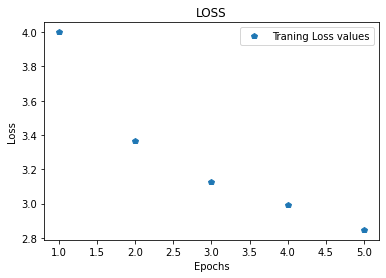

In [25]:
import matplotlib.pyplot as plt
loss = summary['loss']
epochs = range(1, 6)
plt.plot(epochs, loss, 'p', label = "Traning Loss values")
plt.title("LOSS")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoint/ckpt_5'

In [27]:
model = build_model(vocab_size, emdb_dimension, rnn_units, batch_size=1)

In [28]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))#loading the weights which saved in checkppint_dir
model.build(tf.TensorShape([1, None]))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            18176     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 512)            1182720   
_________________________________________________________________
dense_1 (Dense)              (1, None, 71)             36423     
Total params: 1,237,319
Trainable params: 1,237,319
Non-trainable params: 0
_________________________________________________________________


In [30]:
input_eval = [12]
print(input_eval)
input_eval = tf.expand_dims(input_eval, 0)#here shape will be changed(previously-shape(1) now changed to (1, 1))
print(input_eval)
prediction = model(input_eval)#return the the 71 differnt character with there probabilty weights assigned
print(prediction)
prediction = tf.squeeze(prediction, 0)#squeeze the prediction values means it returns same values 
print(prediction)
predicted_id = tf.random.categorical(prediction, num_samples=1)[-1, 0].numpy()
print(predicted_id)#returns the highest probabilty weight from 71 different characters

[12]
tf.Tensor([[12]], shape=(1, 1), dtype=int32)
tf.Tensor(
[[[-0.13270259  0.32789737  1.3124948   0.00421956 -0.4017403
    0.20216897 -0.372234   -0.3668898  -0.4272323   0.4502529
    0.01286751  0.15797219 -0.17478728 -0.19867405 -0.11603794
   -0.19896992 -0.28830904 -0.4835006  -0.3805571  -0.34343147
   -0.44547668 -0.43933803 -0.2242952  -0.12431761 -0.38017157
   -0.41741934 -0.4257754  -0.40432802 -0.4126151  -0.19524828
   -0.3551266  -0.39135623 -0.3252402  -0.24696824 -0.1285213
   -0.3221918  -0.554889   -0.30135128 -0.3316343  -0.22925127
   -0.483322   -0.50710773 -0.39326313 -0.5697083   0.1486722
   -0.11794858 -0.0264941   0.37183422  0.37766668 -0.09059794
    0.04889245  0.25570935  0.26281494 -0.35512397 -0.03960874
    0.09182304  0.04807552  0.20820467  0.16627555 -0.05855139
   -0.3421222   0.50589204  0.04047975  0.08253589  0.0206752
    0.00167432 -0.06126424 -0.28611082  0.12226263 -0.3950675
   -0.4694034 ]]], shape=(1, 1, 71), dtype=float32)
tf.Tensor(


In [31]:
def generate_text(model, start_string):#generating the text through the model by giving the input(start_string)
  num_generate = 500 #it will generate 500 text 

  input_eval = [char2id[d] for d in start_string]#Giving the unique index to each character in input string
  input_eval = tf.expand_dims(input_eval, 0)#here shape will be changed

  text_generated = []

  temperature = 1
  model.reset_states()
  for i in range(num_generate):
    prediction = model(input_eval)#so assigning  the input string to the model and getting the predictions
    prediction = tf.squeeze(prediction, 0)#squeezing the predictions 
    prediction = prediction/temperature
    predicted_id = tf.random.categorical(prediction, num_samples=1)[-1, 0].numpy()

    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(id2char[predicted_id])
  
  return (start_string + "".join(text_generated))

In [32]:
print(generate_text(model, "sister")) #generating the text through the model by giving any input string

sistere l
cihesg t bom

e tis wksl!ot arin._fe nd ain cl Irk tfi un
l ha'bbAeolv
snerctwb he hoint ags ' lf id bobhie Auhileano muidalbd on 'ohood res in thorh iFan abeisnnlh wuood nleghuebocig rSerwiifH
'd e t thel ht ira t rerew ret,r toer thee onlatt ow leny s h lhein
iomnwsm' chnwah, f eemtw E.v re-eeIpouhtf ndren and hisof t l
' waif oetere o g,rynt 


In [33]:
!pip install pyspellchecker

     |████████████████████████████████| 2.5MB 11.6MB/s 


In [34]:
from spellchecker import SpellChecker
spell = SpellChecker()

In [35]:
gen_text = generate_text(model, "turtle")

In [36]:
ls_txt = gen_text.split()

In [37]:
#checking the accuracy of spellings predicted by model
correct_words = spell.unknown(ls_txt)
spell_acc = len(correct_words)/len(ls_txt)
print(spell_acc)

0.6842105263157895
